## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
109971,00029919_003.png,Cardiomegaly|Consolidation|Effusion,3,29919,20,M,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00029919_003.png
90699,00022572_081.png,Atelectasis|Effusion|Nodule,81,22572,51,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00022572_081.png
62416,00015442_030.png,No Finding,30,15442,61,F,AP,2968,2544,0.139,0.139,NaN,/data/images_007/images/00015442_030.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
28703,00007497_008.png,No Finding,8,7497,61,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
35321,00009325_000.png,Atelectasis|Infiltration,0,9325,47,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
38018,00009995_005.png,No Finding,5,9995,62,M,PA,2842,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'T' if x==1 else 'F')

all_xray_df[all_xray_df['Pneumonia']==0].head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,F
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,F


In [5]:
# Number of records with pneumonia = 1431

all_xray_df[all_xray_df['pneumonia_class']=='T']['pneumonia_class'].count()

1431

In [6]:
# Number of records without pneumonia = 110689

all_xray_df[all_xray_df['pneumonia_class']=='F']['pneumonia_class'].count()

110689

## Create your training and testing data:

In [7]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    # train and test split ratio of 80:20 
    train_df, valid_df = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'])
    
    p_inds = train_df[train_df.pneumonia_class=='T'].index.tolist()
    np_inds = train_df[train_df.pneumonia_class=='F'].index.tolist()
    
    # keeping the equal distribution of pneumonia positive and pneumonia negative images in training and validation dataset
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_df.loc[p_inds + np_sample]

    p_inds = valid_df[valid_df.pneumonia_class=='T'].index.tolist()
    np_inds = valid_df[valid_df.pneumonia_class=='F'].index.tolist()

    np_sample = sample(np_inds, len(p_inds))
    val_data = valid_df.loc[p_inds + np_sample]
    
    return train_data, val_data

In [8]:
train_data, val_data = create_splits(all_xray_df)

In [9]:
# number of records with pneumonia in train_data = 1145 

train_data[train_data['pneumonia_class']=='T']['pneumonia_class'].count()

1145

In [10]:
# number of records with pneumonia in val_data = 286 

val_data[val_data['pneumonia_class']=='T']['pneumonia_class'].count()

286

In [11]:
len(train_data), len(val_data)

(2290, 572)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.05, 
                              rotation_range=5,
                              shear_range = 0.1,
                              zoom_range=0.2)
    
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation() 
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224, 224), 
                                          batch_size = 64
                                          )
     # Todo

    return train_gen


def make_val_gen(vargs):
    
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = vargs, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 572 
                                            ) 
    
    # Todo
    return val_gen

In [13]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)

valX, valY = val_gen.next()

Found 572 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


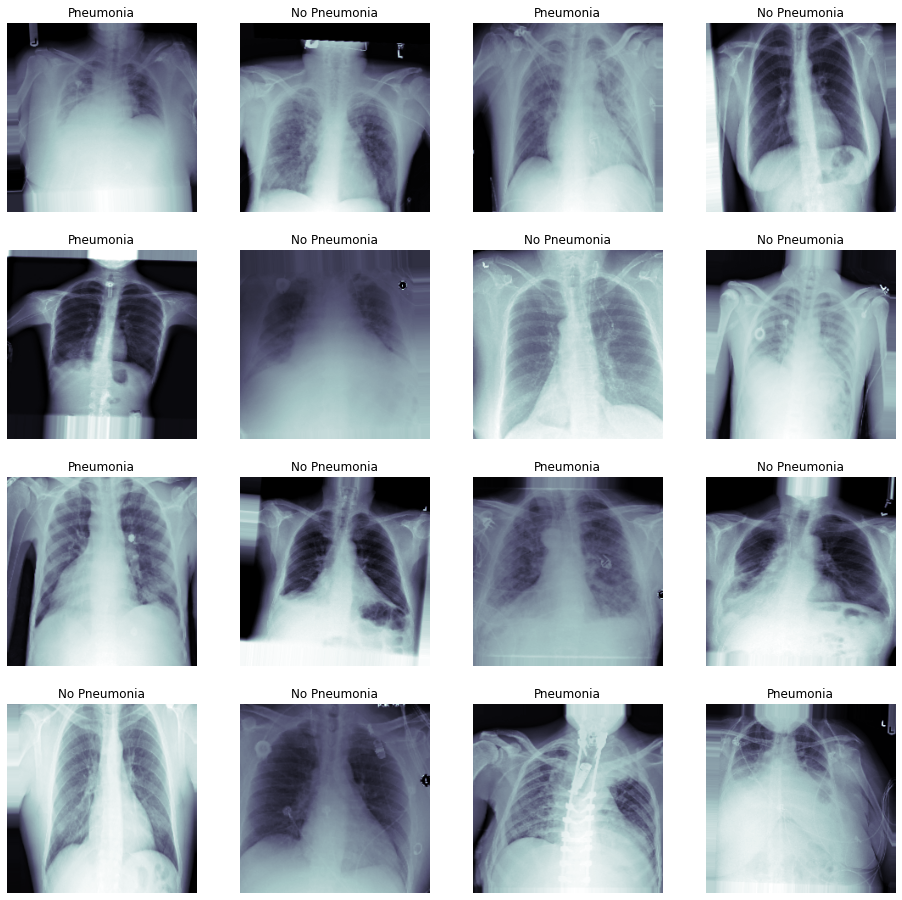

In [71]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_gen = make_train_gen(train_data)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    
    #model.summary()
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo freezing first 14 layers of VGG16 network
    for layer in vgg_model.layers[0:15]:
        layer.trainable = False
    
    return vgg_model


In [15]:
def build_my_model():
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    vgg_model = load_pretrained_model()
    
    my_model.add(vgg_model)
    
    my_model.add(Flatten())
    
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(1024, activation='relu'))
    
    my_model.add(Dropout(0.3))
    
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(0.2))
    
    my_model.add(Dense(1, activation='sigmoid'))
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
my_model = build_my_model()

my_model.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_____________________________________________________

In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'binary_accuracy', 
                      mode= "auto", 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [76]:
## train your model

# Todo
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 40, 
                           callbacks = callbacks_list)

Epoch 1/40
36/36 [==============================] - 64s 2s/step - loss: 0.7437 - binary_accuracy: 0.5131 - val_loss: 0.6769 - val_binary_accuracy: 0.5804

Epoch 00001: binary_accuracy improved from -inf to 0.51310, saving model to xray_class_my_model.best.hdf5
Epoch 2/40
36/36 [==============================] - 60s 2s/step - loss: 0.6878 - binary_accuracy: 0.5568 - val_loss: 0.6597 - val_binary_accuracy: 0.6014

Epoch 00002: binary_accuracy improved from 0.51310 to 0.55677, saving model to xray_class_my_model.best.hdf5
Epoch 3/40
36/36 [==============================] - 60s 2s/step - loss: 0.6757 - binary_accuracy: 0.5821 - val_loss: 0.6531 - val_binary_accuracy: 0.6276

Epoch 00003: binary_accuracy improved from 0.55677 to 0.58210, saving model to xray_class_my_model.best.hdf5
Epoch 4/40
36/36 [==============================] - 60s 2s/step - loss: 0.6616 - binary_accuracy: 0.6166 - val_loss: 0.6459 - val_binary_accuracy: 0.6346

Epoch 00004: binary_accuracy improved from 0.58210 to 0.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [77]:
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    # Todo
    return

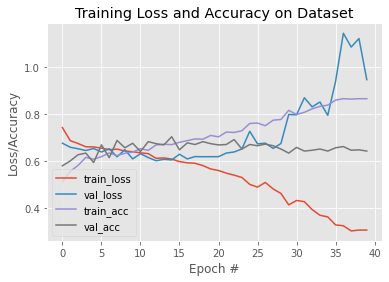

In [78]:
plot_history(history)

In [18]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

572/572 [==============================] - 14s 25ms/step


In [19]:
# merge the prediction with validation dataset

filenames=val_gen.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":pred_Y.squeeze()})

val_data = val_data.merge(results, left_on='path', right_on='Filename')

In [21]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    #return

## what other performance statistics do you want to include here besides AUC? 
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


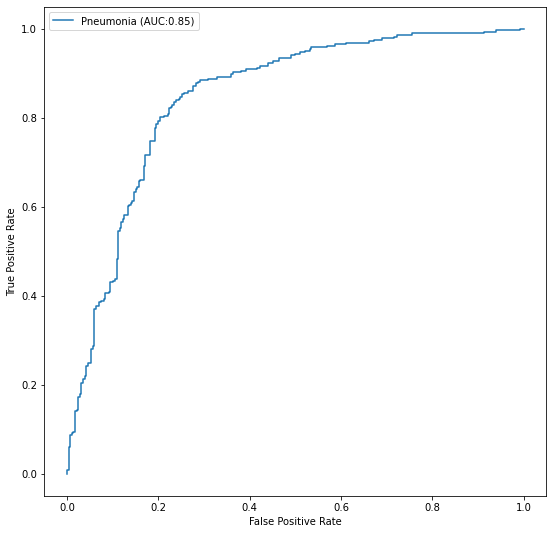

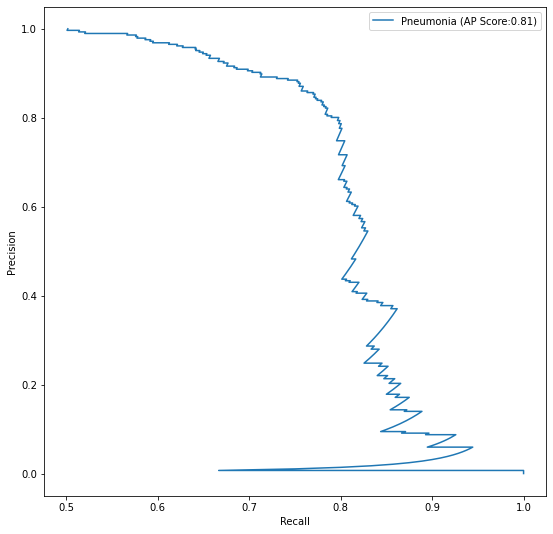

In [23]:
## plot figures

# Area under ROC curve
plot_auc(valY, pred_Y)

# Precision recall curve
plot_pr(valY, pred_Y)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


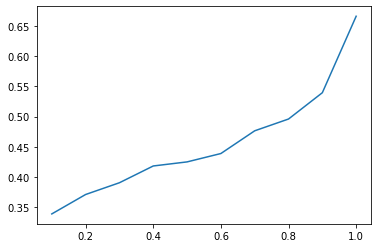

In [23]:
pred_probs = val_data.Predictions

f1_score = []

# Lets evaluate the model f1 score on threshold starting from 0 to 1 in the increment of 0.1
threshold = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for item in threshold: 
    
    val_prediction = (pred_probs > item)
    
    tn, fp, fn, tp = confusion_matrix(val_data.Pneumonia.values, val_prediction,labels=[1,0]).ravel()
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f1_score.append(calc_f1(precision, recall))

plt.plot(threshold, f1_score)

In [25]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
#from sklearn.metrics import f1_score
#print("F1 score", f1_score(valY, pred_Y))

# From the above curve F1 score is maximum at threshold value of 0.99

thres = 0.99
pred_probs = val_data.Predictions
val_prediction = (pred_probs > thres)

tn, fp, fn, tp = confusion_matrix(val_data.Pneumonia.values, val_prediction,labels=[1,0]).ravel()
    
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = calc_f1(precision, recall)

print("precision: ", precision)
print("recall: ", recall)
print("f_score: ", f_score)


sens = tp/(tp+fn)
print("Sentivity: ",sens)

spec = tn/(tn+fp)
print("Specitivity: ",spec)


fp_rate = fp/(fp+tn)

print("False positive rate: ", fp_rate)

fn_rate = fn/(fn+tp)

print("False negative rate: ", fn_rate)

precision:  0.4906832298136646
recall:  0.8286713286713286
f_score:  0.6163849154746424
Sentivity:  0.8286713286713286
Specitivity:  0.13986013986013987
False positive rate:  0.8601398601398601
False negative rate:  0.17132867132867133


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [29]:
# looking at the algorithm's performance in the presence of the other diseases

val_data['Predictions'] = val_prediction

for i in ['Atelectasis','Effusion','Pneumothorax','Infiltration','Cardiomegaly','Mass','Nodule']:

    tn, fp, fn, tp = confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].Predictions.values,labels=[1,0]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))
    print()

Atelectasis
Sensitivity: 0.8333333333333334
Specificity: 0.21621621621621623

Effusion
Sensitivity: 0.7333333333333333
Specificity: 0.13725490196078433

Pneumothorax
Sensitivity: 0.8571428571428571
Specificity: 0.2222222222222222

Infiltration
Sensitivity: 0.8695652173913043
Specificity: 0.11504424778761062

Cardiomegaly
Sensitivity: 0.8888888888888888
Specificity: 0.14285714285714285

Mass
Sensitivity: 0.9166666666666666
Specificity: 0.21428571428571427

Nodule
Sensitivity: 0.8571428571428571
Specificity: 0.09090909090909091



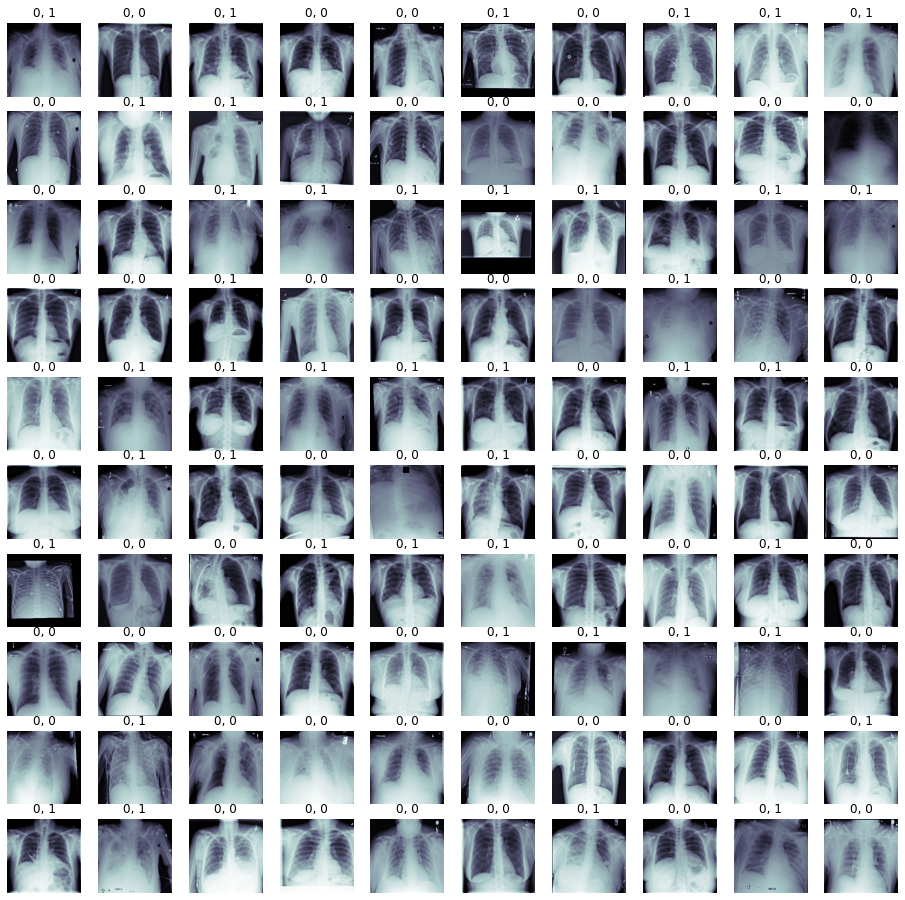

In [30]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo
YOUR_THRESHOLD = 0.6

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], pred_Y[0:100], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > YOUR_THRESHOLD:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > YOUR_THRESHOLD: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [41]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)